# Time delay-cosmography simulations

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy)
- fastell4py (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

The packages are based on Birrer, Amara & Refregier 2015 and an official release is planned with Birrer et al. (in prep)
Installation for each package can be found on the github page.
WARNING: a proper installation of fastell4py   needs a fortran compiler.
This notebook has been tested with lenstronomy 0.2.2.

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util

## simulation choices

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


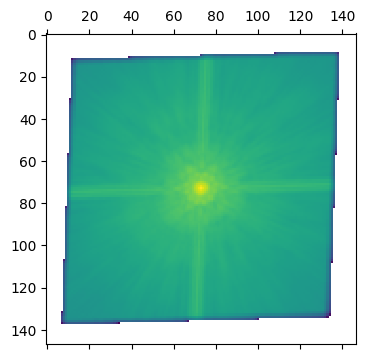

In [2]:
# import main simulation class of lenstronomy
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
sigma_bkg = .2  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
data_class = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
# generate the psf variables
psf_class = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)



/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in log10


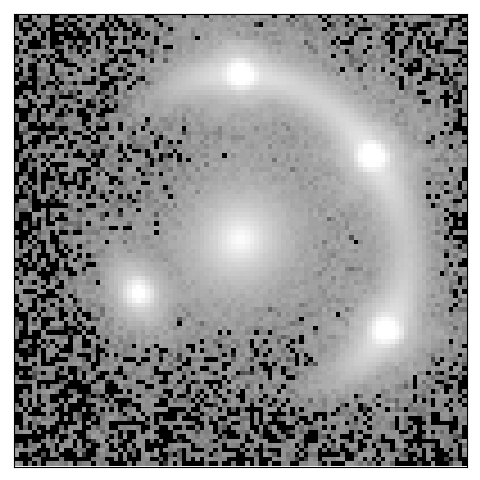

In [3]:
# lensing quantities
kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
kwargs_spemd = {'theta_E': 1.66, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEMD', 'SHEAR']
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'I0_sersic': 10, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'I0_sersic': 20, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = SimAPI.simulate(imageModel, kwargs_lens, kwargs_source,
                                         kwargs_lens_light, kwargs_ps)# update kwargs_data with the newly generated mock
data_class.update_data(image_sim)


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
from lenstronomy.Analysis.lens_properties import LensProp
lensProp = LensProp(z_lens, z_source, kwargs_model, cosmo=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = lensProp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 10]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

('the time delays for the images at position ', array([ 1.45075403,  0.00418142,  1.60583742, -1.12411239]), array([ 0.92026476,  1.81901805, -1.00275344, -0.59088684]), 'are: ', array([-129.40932039, -137.99281327, -142.95283173,  -67.15900101]))
('the measured relative delays are: ', array([-7.49109875, -4.99506471, 65.67722904]))


## kinematics
Kinematics can provide important complementary information about the lens to constrain cosmography

In [5]:
# observational conditions of the spectroscopic campagne
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7

num_evaluate = 1000  # numerical ray-shooting, should converge -> infinity
kwargs_aperture = {'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OsipkovMerritt'
aperture_type = 'slit'

r_ani = 1.
r_eff = 0.2
kwargs_anisotropy = {'r_ani': r_ani}

vel_disp = lensProp.velocity_disperson_numerical(kwargs_lens, kwargs_lens_light, kwargs_anisotropy, kwargs_aperture, psf_fwhm, aperture_type, anisotropy_model, MGE_light=True, MGE_mass=True, r_eff=r_eff)
print(vel_disp, 'velocity dispersion in km/s')

(array([265.42873008]), 'velocity dispersion in km/s')


## Model and parameter choices

In [6]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
#kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'q': 1., 'phi_G': 0.})
kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E_sigma': .1, 'ellipse_sigma':0.1, 'gamma_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({})
#kwargs_lens_init.append({'e1': 0.0, 'e2': 0.0})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'shear_sigma': 0.01})
kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.1, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.05, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'pos_sigma': 0.01, 'pos_sigma': 0.01}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt_sigma': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'cosmography': cosmo_params}

kwargs_model['cosmo_type'] = 'D_dt'

In [7]:


# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_center_lens_light': False,
                              'joint_center_source_light': False,
                              'num_point_source_list': [4],
                              'additional_images_list': [False],
                              'fix_to_point_source_list': [True] * num_source_model,
                              'image_plane_source_list': [False] * num_source_model,
                              'solver': True,
                              'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'point_source_likelihood': False,
                             'position_uncertainty': 0.004,
                             'check_solver': True,
                             'solver_tolerance': 0.001,
                     
                             'time_delay_likelihood': True,
                             'time_delays_measured': dt_measured,
                             'time_delays_uncertainties': dt_sigma,
                             }
kwargs_data = data_class.constructor_kwargs()
kwargs_psf = psf_class.constructor_kwargs()
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
        {'fitting_routine': 'PSO', 'mpi': False, 'sigma_scale': .1, 'n_particles': 50,
         'n_iterations': 50},
        {'fitting_routine': 'MCMC', 'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'mpi': False,
         'sigma_scale': .1}
]

start_time = time.time()
lens_result, source_result, lens_light_result, ps_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
max iteration reached! stoping
(-0.9928541392004682, 'reduced X^2 of best position')
(-4952.852873401535, 'logL')
(9977, 'effective number of data points')
([{'theta_E': 1.6599796091849885, 'center_x': 8.652002396154235e-05, 'center_y': -7.272216112529376e-05, 'e1': 0.10016319594572919, 'gamma': 1.953604769924755, 'e2': 0.10040288418668873}, {'e1': -0.0002992616635844142, 'e2': -0.050379745802443296}], 'lens result')
([{'R_sersic': 0.0998541338440354, 'I0_sersic': 1, 'n_sersic': 1.0020172657359125, 'center_x': 0.20088928517112725, 'center_y': 0.10032333495797724, 'e1': 0.05922499771364162, 'e2': 0.0898097168083875}], 'source result')
([{'R_sersic': 0.19883372915298958, 'I0_sersic': 1, 'n_sersic': 1.9928609925596603, 'center_x': 0.00013658578590811763, 'center_y': -0.0007283261901639465, 'e1': -0.010495647242262573, 'e2': 0.0481372593512381}], 'lens light result')
([{'point_amp': 1, 'ra_image': array([ 1.45064887,  0.0041994 ,  1.6059986 , -1.1240696

## analyse model output

('reduced chi^2 = ', 0.9794787477085025)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:239: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


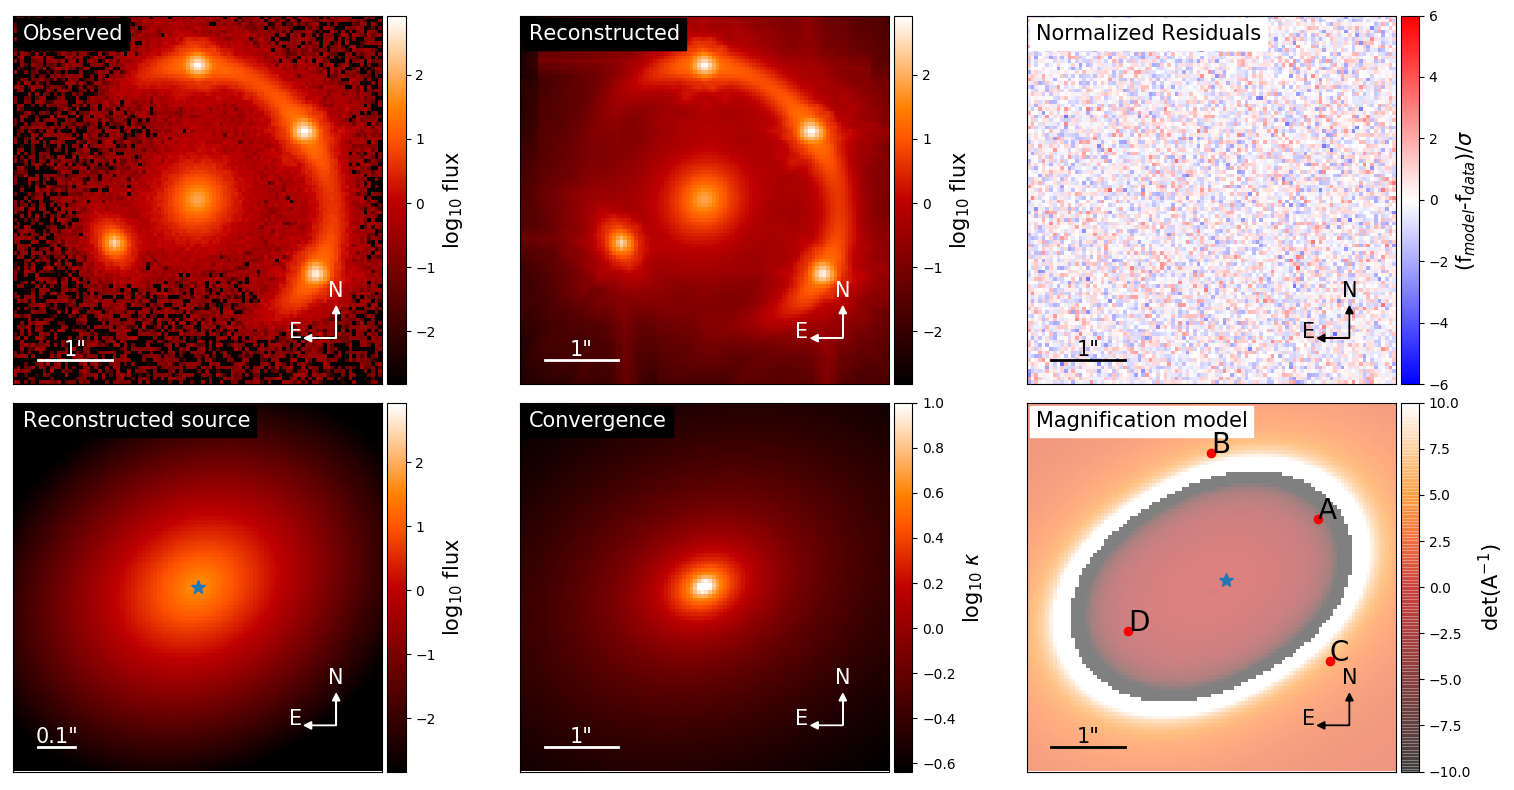

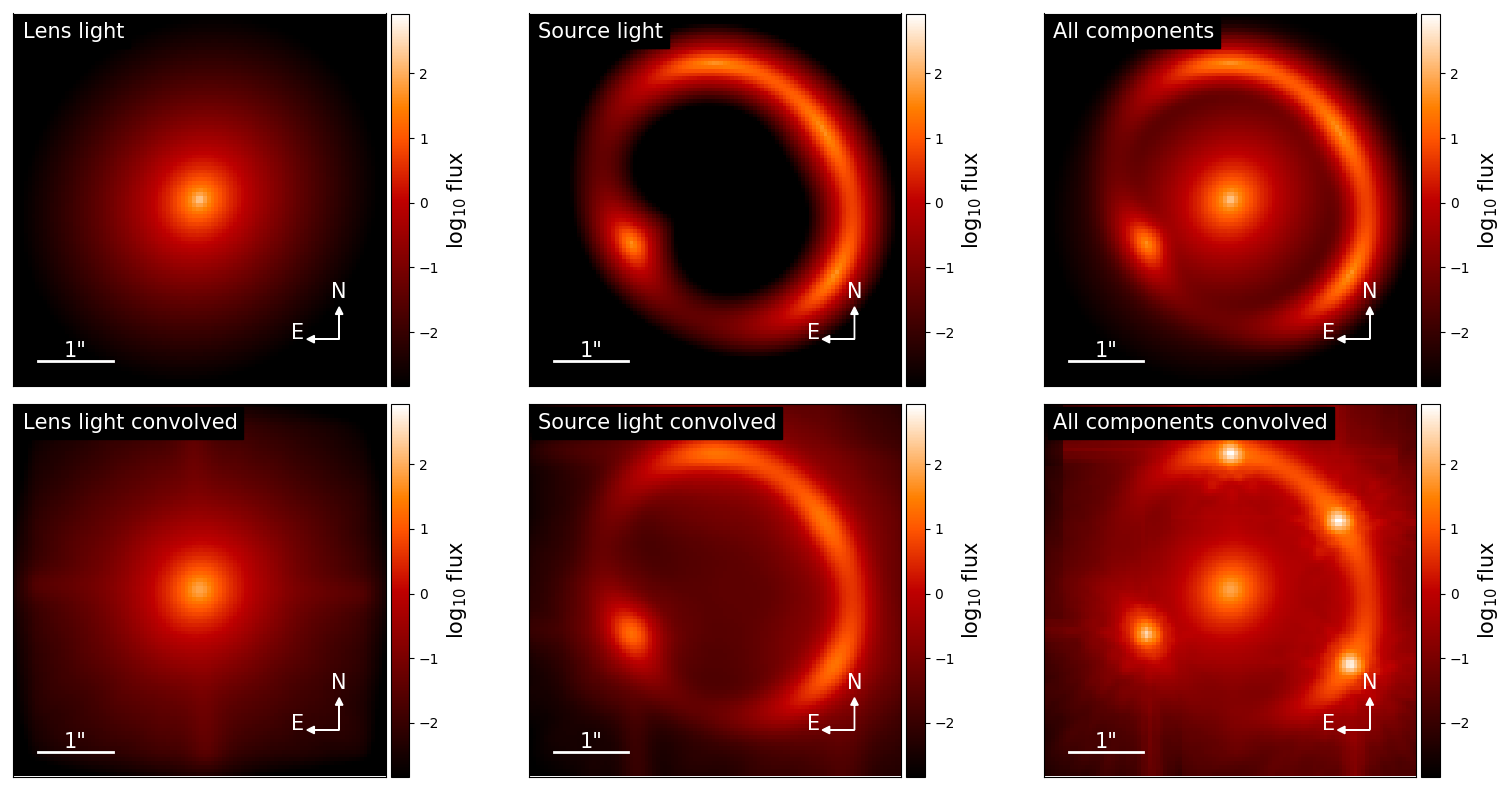

[{'theta_E': 1.6599796091849885, 'center_x': 8.652002396154235e-05, 'center_y': -7.272216112529376e-05, 'e1': 0.10016319594572919, 'gamma': 1.953604769924755, 'e2': 0.10040288418668873}, {'e1': -0.0002992616635844142, 'e2': -0.050379745802443296}] [{'R_sersic': 0.0998541338440354, 'I0_sersic': 10.003180570256822, 'n_sersic': 1.0020172657359125, 'center_x': 0.20088928517112725, 'center_y': 0.10032333495797724, 'e1': 0.05922499771364162, 'e2': 0.0898097168083875}] [{'R_sersic': 0.19883372915298958, 'I0_sersic': 20.02766604855871, 'n_sersic': 1.9928609925596603, 'center_x': 0.00013658578590811763, 'center_y': -0.0007283261901639465, 'e1': -0.010495647242262573, 'e2': 0.0481372593512381}] [{'point_amp': array([6620.43378149, 5955.88444398, 5078.47124226, 1939.66596554]), 'ra_image': array([ 1.45064887,  0.0041994 ,  1.6059986 , -1.1240696 ]), 'dec_image': array([ 0.92048801,  1.81900635, -1.00273661, -0.59114074])}]


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:552: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


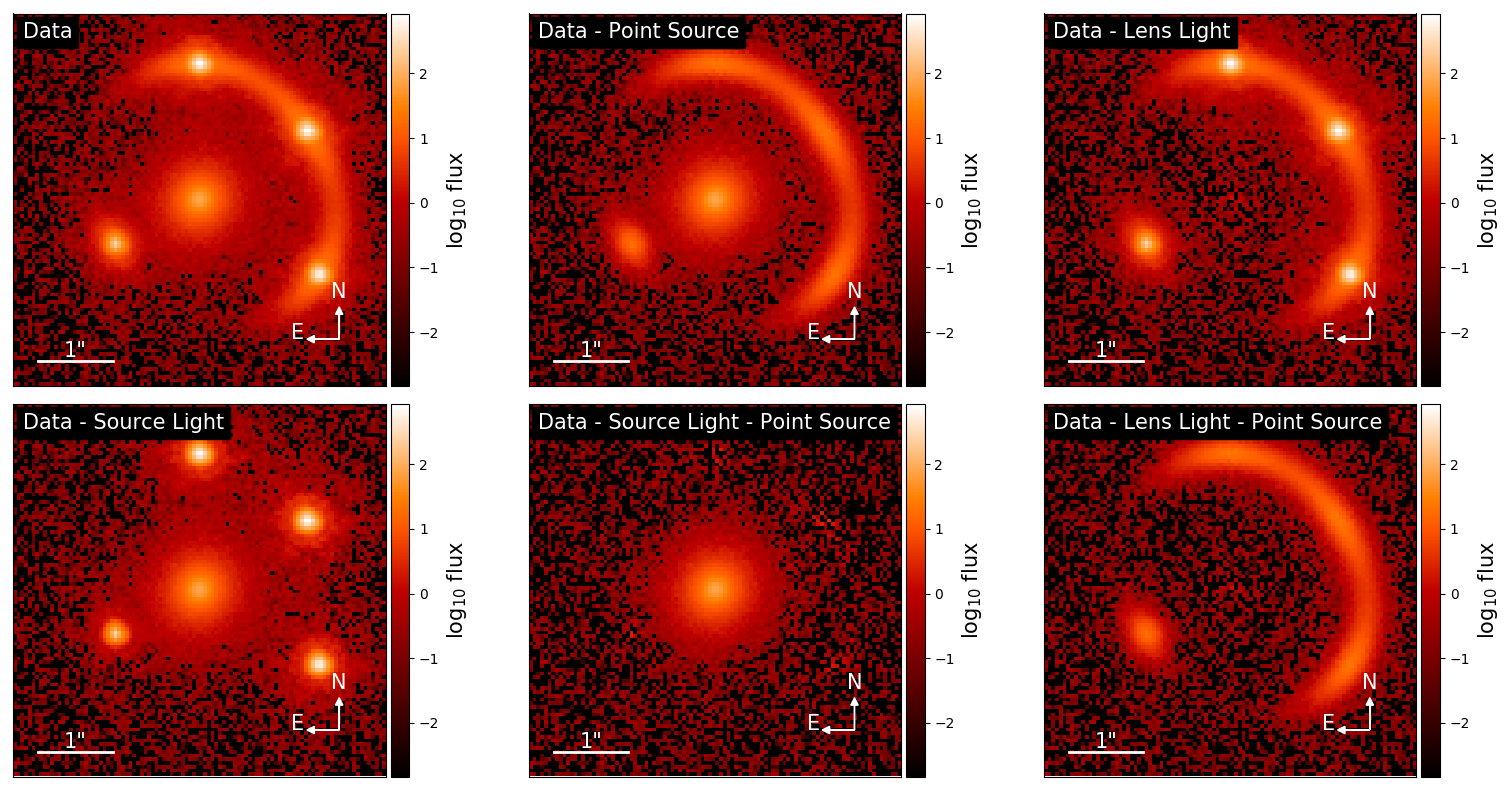

In [8]:
import lenstronomy.Plots.output_plots as out_plot

from lenstronomy.Plots.output_plots import LensModelPlot

lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0,0])
lensPlot.model_plot(ax=axes[0,1])
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
lensPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print lens_result, source_result, lens_light_result, ps_result
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.subtract_from_data_plot(ax=axes[0,0], text='Data')
lensPlot.subtract_from_data_plot(ax=axes[0,1], text='Data - Point Source', point_source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[0,2], text='Data - Lens Light', lens_light_add=True)
lensPlot.subtract_from_data_plot(ax=axes[1,0], text='Data - Source Light', source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[1,1], text='Data - Source Light - Point Source', source_add=True, point_source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[1,2], text='Data - Lens Light - Point Source', lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens', 'e1', 'e2', 'n_sersic_source_light', 'R_sersic_source_light', 'e1_source_light', 'e2_source_light', 'center_x_lens_light', 'center_y_lens_light', 'n_sersic_lens_light', 'R_sersic_lens_light', 'e1_lens_light', 'e2_lens_light', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  22000


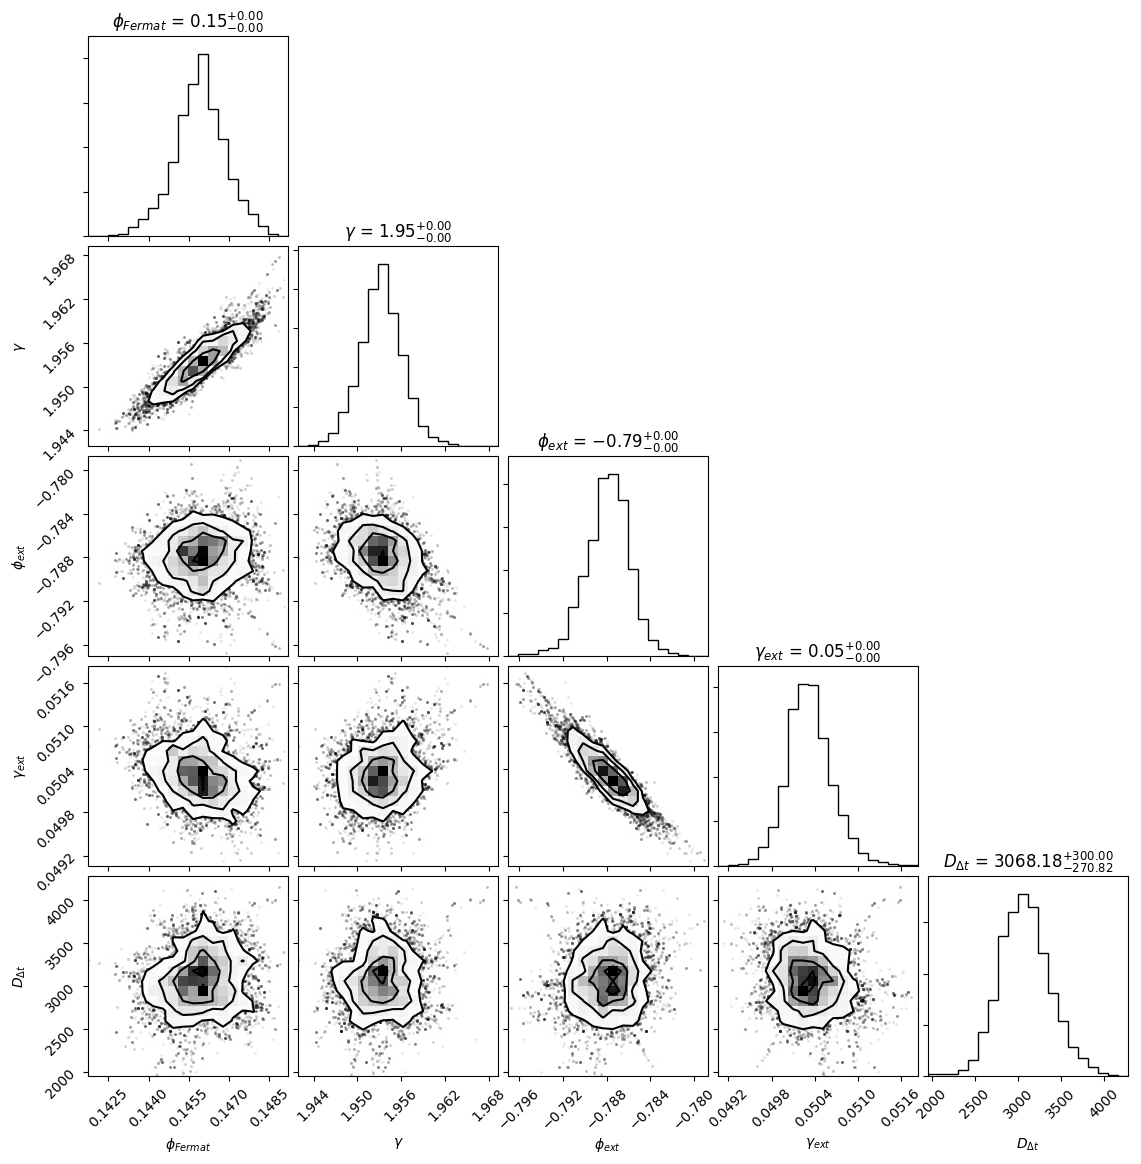

In [9]:
print "number of non-linear parameters in the MCMC process: ", len(param_mcmc)
print "parameters in order: ", param_mcmc
print "number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0]
import corner


# import the parameter handling class #
from lenstronomy.Workflow.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, kwargs_constraints, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_lens)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.lens_analysis import LensAnalysis
lensAnalysis = LensAnalysis(kwargs_model)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out = param.getParams(samples_mcmc[i])
    kwargs_cosmo = param.getCosmo(samples_mcmc[i])
    D_dt = kwargs_cosmo['D_dt']
    fermat_pot = lensAnalysis.fermat_potential(kwargs_lens_out, kwargs_ps_out)
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_lens_out[0]['gamma']
    phi_ext, gamma_ext = lensAnalysis.LensModel.external_shear(kwargs_lens_out)
    mcmc_new_list.append([delta_fermat_12, gamma, phi_ext, gamma_ext, D_dt])


plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

In [10]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
print lensCosmo.D_dt

3363.9353754
